## Task Discription

Objective: Build an application that collects news articles from various RSS feeds (e.g: listed
below), stores them in a database, and categorizes them into predefined categories.
Categories the news item should fall under are:
● Terrorism / protest / political unrest / riot
● Positive/Uplifting
● Natural Disasters
● Others



List of RSS Feeds:
● http://rss.cnn.com/rss/cnn_topstories.rss

● http://qz.com/feed
● http://feeds.foxnews.com/foxnews/politics
● http://feeds.reuters.com/reuters/businessNews
● http://feeds.feedburner.com/NewshourWorld
● https://feeds.bbci.co.uk/news/world/asia/india/rss.xml



Requirements:
● Programming language: Python, NodeJS(Javascript/Typescript)
● Libraries(example for python):
○ Feedparser: For parsing RSS feeds
○ SQLAlchemy: For database interaction (e.g., PostgreSQL)
○ Celery: For managing the task queue
○ Natural Language Processing (NLTK or spaCy) for text classification
● Database: Any relational database (e.g., PostgreSQL, MySQL)
Note: These are examples, please feel free to use any relevant libraries and frameworks.



Additional detail for the Assignment task**:**

1. Feed Parser and Data Extraction:
○ Create a script that reads the provided list of RSS feeds.
○ Parse each feed and extract relevant information from each news article,
including title, content, publication date, and source URL.
○ Ensure handling of duplicate articles from the same feed.

2. Database Storage:
○ Design a database schema to store the extracted news article data.
○ Implement logic to store new articles in the database without duplicates.

3. Task Queue and News Processing:
○ Set up a Celery queue to manage asynchronous processing of new articles.
○ Configure the parser script to send extracted articles to the queue upon arrival.
○ Create a Celery worker that consumes articles from the queue and performs
further processing:
■ Category classification: Utilize NLTK or spaCy to classify each article into
the provided categories.
■ Update the database with the assigned category for each article.

4. Logging and Error Handling:
○ Implement proper logging throughout the application to track events and potential
errors.
○ Handle parsing errors and network connectivity issues gracefully.



Deliverables:
● Python code for the application
● Documentation explaining the implemented logic and design choices.
● The resulting data as sqldump, csv or json.
This enhanced test task will comprehensively assess your abilities in:
● Building and managing complex ETL pipelines.
● Building other scheduling and distributed task management infrastructure
● Working with data sources(RSS, APIs,etc)
● Implementing existing machine learning models
Note: This is a general outline of the test task. Feel free to add your own creative flair and
showcase your problem-solving and technical skills through the implementation. This should not
take you more than a single day.

## Step -1 : Parsing the RSS Feeds


RSS Feed URL's have essentially XML like structure. Let us use a combination of 'BeautifulSoup' & 'requests' library to inspect the file structure for rlevant informations :

In [1]:
import requests
from bs4 import BeautifulSoup

# CNN News Top Stories-- RSS Feed URL
url = ' http://rss.cnn.com/rss/cnn_topstories.rss'

resp= requests.get(url)
                  
# Since we're parsing a XML file we use the features parameter to specify it
## We create a 'soup'variable/ object to store an instance of the BeautifulSoup object
soup = BeautifulSoup(resp.content, features = 'xml')

### We use prettify to view a structured layout of the feed

In [2]:
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<rss version="2.0" xmlns:atom="http://www.w3.org/2005/Atom" xmlns:content="http://purl.org/rss/1.0/modules/content/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:media="http://search.yahoo.com/mrss/">
 <channel>
  <title>
   CNN.com - RSS Channel - HP Hero
  </title>
  <description>
   CNN.com delivers up-to-the-minute news and information on the latest top stories, weather, entertainment, politics and more.
  </description>
  <link>
   https://www.cnn.com/index.html
  </link>
  <image>
   <url>
    http://i2.cdn.turner.com/cnn/2015/images/09/24/cnn.digital.png
   </url>
   <title>
    CNN.com - RSS Channel - HP Hero
   </title>
   <link>
    https://www.cnn.com/index.html
   </link>
  </image>
  <generator>
   coredev-bumblebee
  </generator>
  <lastBuildDate>
   Tue, 30 Jan 2024 18:54:05 GMT
  </lastBuildDate>
  <pubDate>
   Tue, 18 Apr 2023 21:25:59 GMT
  </pubDate>
  <copyright>
   Copyright (c) 2024 Turner Broadcasting System, Inc. All R

### We notice after inspecting the contents of the soup object above that the news articles are stored within 'item' tags within the xml file
### So we use the 'find_all' method to search & fetch all the contents stored within 'item' tags in the file
### This will help us find all the relevant articles

In [3]:
items = soup.find_all('item')
items

[<item><title>Some on-air claims about Dominion Voting Systems were false, Fox News acknowledges in statement after deal is announced</title><link>https://www.cnn.com/business/live-news/fox-news-dominion-trial-04-18-23/index.html</link><guid isPermaLink="true">https://www.cnn.com/business/live-news/fox-news-dominion-trial-04-18-23/index.html</guid><pubDate>Wed, 19 Apr 2023 12:44:51 GMT</pubDate><media:group><media:content height="619" medium="image" type="image/jpeg" url="https://cdn.cnn.com/cnnnext/dam/assets/230418164538-02-dominion-fox-trial-settlement-0418-super-169.jpg" width="1100"/><media:content height="300" medium="image" type="image/jpeg" url="https://cdn.cnn.com/cnnnext/dam/assets/230418164538-02-dominion-fox-trial-settlement-0418-large-11.jpg" width="300"/><media:content height="552" medium="image" type="image/jpeg" url="https://cdn.cnn.com/cnnnext/dam/assets/230418164538-02-dominion-fox-trial-settlement-0418-vertical-large-gallery.jpg" width="414"/><media:content height="4

### Let's check the number of articles contained within the xml file, by checking the length of the 'items' object

In [4]:
len(items)

69

### So there are '69' articles contained within this file

### We can now fetch the various news articles from this 'items' object , using the index operator along with the respective index

### Let us inspect the first news artcile in the xml file

In [5]:
# Example: First Article
news_data_1 = items[0]
news_data_1

<item><title>Some on-air claims about Dominion Voting Systems were false, Fox News acknowledges in statement after deal is announced</title><link>https://www.cnn.com/business/live-news/fox-news-dominion-trial-04-18-23/index.html</link><guid isPermaLink="true">https://www.cnn.com/business/live-news/fox-news-dominion-trial-04-18-23/index.html</guid><pubDate>Wed, 19 Apr 2023 12:44:51 GMT</pubDate><media:group><media:content height="619" medium="image" type="image/jpeg" url="https://cdn.cnn.com/cnnnext/dam/assets/230418164538-02-dominion-fox-trial-settlement-0418-super-169.jpg" width="1100"/><media:content height="300" medium="image" type="image/jpeg" url="https://cdn.cnn.com/cnnnext/dam/assets/230418164538-02-dominion-fox-trial-settlement-0418-large-11.jpg" width="300"/><media:content height="552" medium="image" type="image/jpeg" url="https://cdn.cnn.com/cnnnext/dam/assets/230418164538-02-dominion-fox-trial-settlement-0418-vertical-large-gallery.jpg" width="414"/><media:content height="48

### Let's parse this individual news article, to obtain the necessary informations from this article, including (title, content, publication date, and source URL.)
### XMl/ Html files often have a hiearchical structure.
### So to fetch specific pieces of informations from the structure we may need to, use the different tags within the xml file as the different methods leading upto the specific piece of information that we're targeting

In [7]:
### For example :
# To fetch the title info from the 'title' tag we use, the title as a method directly on the 'first_article' object

news_data_1.title

<title>Some on-air claims about Dominion Voting Systems were false, Fox News acknowledges in statement after deal is announced</title>

In [8]:
## If we want to fetch only the Title and get rid of the title tags , we can use the 'text' method on it:
news_data_1.title.text

'Some on-air claims about Dominion Voting Systems were false, Fox News acknowledges in statement after deal is announced'

### Similarly we can fetch all the relevant pieces of informations that we require, such as title, content, publication date, and source URL :

In [10]:
from newspaper import Article

# RSS feed article url
url = news_data_1.link.text

# Creating an Article object
news_data = Article(url)

# Downloading and parsing the article content
news_data.download()
news_data.parse()

# Extracting the natural language processing features (optional)
news_data.nlp()

# Printing the various attributes of the article
print("Title:", news_data.title)
print("Authors:", news_data.authors)
print("Publish Date:", news_data.publish_date)
print("Text:", news_data.text)


Title: Settlement reached in Fox vs Dominion lawsuit
Authors: ['Catherine Thorbecke', 'Mike Hayes', 'Maureen Chowdhury', 'Marshall Cohen', 'Oliver Darcy', 'Jon Passantino', 'Elise Hammond', 'Tori B. Powell']
Publish Date: 2023-04-18 15:02:55+00:00
Text: Justin Nelson, Dominion's lead counsel, appears on CNN. (CNN)

Dominion Voting Systems had two goals in its defamation case against Fox News — accountability and “trying to make Dominion whole," said Justin Nelson, the lead counsel election technology company.

Both were accomplished in this settlement, he told CNN on Tuesday.

The payment of more than $787 million by Fox News to Dominion and the network's statement acknowledging that its coverage of the 2020 election was false was “a strong message of accountability” and an important victory for the employees of his client's company.

“This is really the first time that anyone has paid a price for telling the lies of the 2020 election and we're very proud about that," he said.

While t

### To streamline the entire parsing process we can use the 'feedparser' python library as used below :

In [11]:
import feedparser
from newspaper import Article

# Rss_feed_url
rss_feed_url = 'http://rss.cnn.com/rss/cnn_topstories.rss'
                
# Parsing the RSS feed using feedparser
parsed_feed = feedparser.parse(rss_feed_url)

# Iterating through the entries in the feed
for entry in parsed_feed.entries:
    # Geting the URL of the article from the entry
    article_url = entry.link

    # Creating an Article object using newspaper
    news_data = Article(article_url)

    try:
        # Downloading and parsing the article content
        news_data.download()
        news_data.parse()

        # Extracting information from the Article object
        title = news_data.title
        authors = news_data.authors
        publish_date = news_data.publish_date
        text = news_data.text
        
        # Extracting natural language processing features
        news_data.nlp()

        # Printing the extracted information as needed
        
        print("Title:", title)
        print("Content:", text)
        print("Publication Date:", publish_date)
        print('Source URL ',article_url)
        print('=' * 108)
        print('=' * 108)
        #print("----")

    except Exception as e:
        print(f"Error processing article at {article_url}: {e}")


Title: Settlement reached in Fox vs Dominion lawsuit
Content: Justin Nelson, Dominion's lead counsel, appears on CNN. (CNN)

Dominion Voting Systems had two goals in its defamation case against Fox News — accountability and “trying to make Dominion whole," said Justin Nelson, the lead counsel election technology company.

Both were accomplished in this settlement, he told CNN on Tuesday.

The payment of more than $787 million by Fox News to Dominion and the network's statement acknowledging that its coverage of the 2020 election was false was “a strong message of accountability” and an important victory for the employees of his client's company.

“This is really the first time that anyone has paid a price for telling the lies of the 2020 election and we're very proud about that," he said.

While the settlement does not stipulate that Fox’s anchors must acknowledge the lies on air, Nelson said it was a consequential outcome for the network.

The texts and emails that emerged during the 

Title: Fox News settles with Dominion for $787 million, averting defamation trial over its 2020 election lies
Content: Wilmington, Delaware CNN —

Fox News reached a last-second settlement with Dominion Voting Systems on Tuesday as the case raced toward opening statements, paying more than $787 million to end a colossal two-year legal battle that publicly shredded the right-wing network’s credibility.

Fox News’ $787.5 million settlement with Dominion Voting Systems is the largest publicly known defamation settlement in US history involving a media company.

The deal was announced hours after the jury was sworn in at the Delaware Superior Court. Rumors of a settlement swirled in the courthouse when, after a lunch break, the proceedings dramatically ground to a halt for nearly three hours with no explanation, while the parties apparently hammered out an accord.

Attorneys representing Dominion Voting Systems, leave the New Castle County Courthouse in Wilmington, Del., after the defamati

Title: The White homeowner accused of shooting a Black teen who rang his doorbell turns himself in and is released on bail
Content: CNN —

The 84-year-old White man accused of shooting a Black teenager who rang his doorbell in Kansas City turned himself in Tuesday and was later released on bail, authorities said.

Andrew Lester, who faces two felony charges – assault in the first degree and armed criminal action – in the April 13 shooting of Ralph Yarl, will be arraigned Wednesday afternoon, according to Yarl family attorney Lee Merritt. CNN has reached out to prosecutors to confirm the information.

Lester turned himself in at a detention center Tuesday then hours later was released on bail. The conditions of his $200,000 bond prohibit him from having any type of weapon and cannot have direct or indirect contact with Yarl or his family, according to Clay County Sheriff’s Office spokesperson Sarah Boyd.

Ralph, 16, was shot in the head and arm after he went to the wrong address to pick

Title: Video: Bodycam footage shows aftermath of Jeremy Renner's snowplow accident
Content: 1. How relevant is this ad to you?

Video player was slow to load content Video content never loaded Ad froze or did not finish loading Video content did not start after ad Audio on ad was too loud Other issues
Publication Date: 2023-04-18 00:00:00
Source URL  https://www.cnn.com/videos/us/2023/04/18/jeremy-renner-snowplow-accident-bodycam-nc-melas-contd-vpx.cnn
Title: Jake Gyllenhaal and Jamie Lee Curtis spent the Covid-19 lockdown together
Content: CNN —

It’s sourdough bread and handstands for Jake Gyllenhaal and Jamie Lee Curtis.

The two stars are talking about the time they spent together during the Covid-19 pandemic, telling People that the actor, who is Lee’s godson, and his girlfriend Jeanne Cadieu, lived in the house next door that Curtis owns. Curtis, who won best supporting actress Oscar at lthe 2023 Academy Awards, is friends with Gyllenhaal’s parents, director Stephen Gyllenhaal an

Title: See pizza delivery guy take out suspect fleeing police
Content: 1. How relevant is this ad to you?

Video player was slow to load content Video content never loaded Ad froze or did not finish loading Video content did not start after ad Audio on ad was too loud Other issues
Publication Date: 2023-04-18 00:00:00
Source URL  https://www.cnn.com/videos/us/2023/04/18/pizza-guy-trips-perp-moos-cprog-orig-bdk.cnn
Title: Netflix is winding down its DVD business after 25 years
Content: 1. How relevant is this ad to you?

Video player was slow to load content Video content never loaded Ad froze or did not finish loading Video content did not start after ad Audio on ad was too loud Other issues
Publication Date: 2023-04-18 00:00:00
Source URL  https://www.cnn.com/2023/04/18/media/netflix-dvd-red-envelopes/index.html
Title: FTC chair Lina Khan warns AI could ‘turbocharge’ fraud and scams
Content: Washington CNN —

Artificial intelligence tools such as ChatGPT could lead to a “turbocharging

Title: Watch: Apple CEO Tim Cook inaugurates first Apple store in India
Content: 1. How relevant is this ad to you?

Video player was slow to load content Video content never loaded Ad froze or did not finish loading Video content did not start after ad Audio on ad was too loud Other issues
Publication Date: 2023-04-18 00:00:00
Source URL  https://www.cnn.com/videos/tech/2023/04/18/apple-store-mumbai-india-ceo-tim-cook-vedika-sud-ovn-biz-ldn-vpx.cnn
Title: Democrats bash Justice Clarence Thomas but their plan to investigate ethics allegations is unclear
Content: CNN —

Senate Democrats railed against Justice Clarence Thomas on Tuesday amid reports that the Supreme Court conservative failed to disclose luxury travel, gifts and a real estate transaction involving a GOP megadonor, but their plan to investigate the conservative jurist remains unclear.

Senate Judiciary Chairman Dick Durbin has promised that his committee will hold a hearing on the alleged ethics violations in the coming we

Title: Two Russians claiming to be former Wagner commanders admit killing children and civilians in Ukraine
Content: CNN —

Two Russian men who claim to be former Wagner Group commanders have told a human rights activist that they killed children and civilians during their time in Ukraine.

The claims were made in video interviews with Gulagu.net, a human rights organization targeting corruption and torture in Russia.

In the video interviews posted online, former Russian convicts Azamat Uldarov and Alexey Savichev – who were both pardoned by Russian presidential decrees last year, according to Gulagu.net – described their actions in Ukraine, during Russia’s invasion.

CNN cannot independently verify their claims or identities in the videos but has obtained Russian penal documents showing they were released on presidential pardon in September and August of 2022.

Uldarov, who appears to have been drinking, details how he shot and killed a five- or six-year-old girl.

“(It was) a manage

Title: McCurtain County, Oklahoma, recording: Governor calls on officials to resign over recording of racist and threatening remarks
Content: CNN —

The governor of Oklahoma is calling on four McCurtain County officials to resign after they allegedly participated in a secretly recorded conversation that included racist remarks about lynching Black people and talking about killing journalists.

The McCurtain Gazette-News over the weekend published the audio it said was recorded following a Board of Commissioners meeting on March 6.

The paper said the audio of the meeting was legally obtained, but the McCurtain County Sheriff’s Office said in a statement that it was illegally recorded and is investigating. The sheriff’s office also said it believes the recording had been altered.

“I am both appalled and disheartened to hear of the horrid comments made by officials in McCurtain County,” Gov. Kevin Stitt said in a statement Sunday. “There is simply no place for such hateful rhetoric in t

Title: Watch: Video shows moment Indian politician was shot on live TV
Content: 1. How relevant is this ad to you?

Video player was slow to load content Video content never loaded Ad froze or did not finish loading Video content did not start after ad Audio on ad was too loud Other issues
Publication Date: 2023-04-18 00:00:00
Source URL  https://www.cnn.com/videos/world/2023/04/18/india-ex-lawmaker-atiq-ahmed-assassination-sud-pkg-contd-ovn-intl-hnk-vpx.cnn
Title: FDA clears the way for additional bivalent boosters for certain vulnerable individuals
Content: CNN —

The U.S. Food and Drug Administration amended the terms of its emergency use authorizations for the Pfizer and Moderna bivalent vaccines on Tuesday, allowing people ages 65 and older and certain people with weakened immunity to get additional doses before this fall’s vaccination campaigns.

The bivalent vaccines made by Pfizer and Moderna carry instructions for fighting both the original strain of the Covid-19 virus as well

Title: Southwest Airlines flights grounded due to equipment issues
Content: CNN —

Hundreds of Southwest Airlines flights were delayed after technical issues that prompted the airline to temporarily halt its operations on Tuesday morning.

Southwest said the flight delays were the result of “data connection issues resulting from a firewall failure,” a problem that led to a brief ground stop.

The Federal Aviation Administration initiated the ground stop at the airline’s request, citing “equipment issues.” The ground stop was soon lifted, and in a tweet at 11:35 a.m. ET Southwest said it had resumed operations.

“Early this morning, a vendor-supplied firewall went down and connection to some operational data was unexpectedly lost,” spokesman Dan Landson said in a statement.

Southwest had delayed 1,820 flights or 43% of its schedule as of just after noon Tuesday, according to FlightAware. The airline has canceled only nine flights on Tuesday, according to FlightAware. Southwest says its

Title: Fulton County DA says fake Trump electors are incriminating one another
Content: CNN —

The Fulton County District Attorney’s office said some fake electors for Donald Trump have implicated each other in potential criminal activity and is seeking to disqualify their lawyer, according to a new court filing.

The district attorney’s office is requesting that attorney Kimberly Bourroughs Debrow be disqualified from representing a group of 10 Republicans who served as electors for the former president in Georgia – a state Trump lost to President Joe Biden. The DA’s office also accused the lawyer of failing to present an immunity deal to her clients last year, according to the filing.

The new filing offers the latest indication that immunity offers could still be in the works months after Fulton County District Attorney Fani Willis suggested charging decisions were “imminent.”

It notes that investigators interviewed some of the fake GOP electors this month and there is jockeying be

Title: The Assignment with Audie Cornish
Content: Can Country music help lead the U.S. out of the gun debate? There is a long history of famous country musicians using their platforms to comment on social and political issues. But since the lead singer of The Chicks, Natalie Maines, was ostracized after criticizing then President George W. Bush, country music stars have felt safer keeping their political views out of the public eye. Musician Ketch Secor of the band Old Crow Medicine Show is trying to change that. After the shooting at Covenant School in Nashville, Tennessee, Ketch wrote an Op-ed in The New York Times calling for country music stars to let go of the fear of retaliation from their fanbase, and to break their silence on the gun debate. Audie talks with Ketch about what it’s like to be a musician and a parent in Nashville right now and what he thinks country musicians can do to help prevent another mass shooting.

Download Transcript Episode Transcript

Audie Cornish 00:00

Title: Tax Day: Here's what you need to know if you haven't filed your return yet — and even if you have
Content: Editor’s Note: This is an updated version of a story that originally ran on April 14, 2023.

New York CNN —

It’s April 18, the official deadline to file your federal and state income tax returns for 2022. (It is also, apparently, National Animal Crackers Day for those who celebrate.)

Whether you have already filed your tax return or still need to, the good news is this tax filing season has gone much more smoothly than the past three, which were hurt by the pandemic.

“This is the first tax season since 2019 where the IRS and the nation were on normal footing,” IRS Commissioner Danny Werfel said in a call with reporters.

For instance, Werfel noted that since January, thanks to an infusion of some new funding after years of budget cuts, IRS employees have been able to answer 87% of calls from filers with questions. Last year, they answered fewer than 15%. And the wait tim

Title: Undocumented immigrants are paying their taxes today, too
Content: Editor’s Note: A version of this story first published in 2019.

CNN —

It’s a surprising fact that’s often overlooked in the immigration debate.

Undocumented immigrants pay billions of dollars in federal taxes annually, between tax returns filed and taxes deducted from paychecks, experts estimate.

Here’s a look at why – and how – this is happening.

Why some undocumented immigrants choose to pay taxes

The National Immigration Law Center breaks down a number of reasons why undocumented immigrants pay taxes, including:

• It shows they’re complying with federal tax laws.

• It can help them demonstrate “good moral character” if they later have an opportunity to legalize their immigration status.

• Tax return records could be used to document work history and presence in the US, steps that may help them be eligible for legal immigration status in the future if lawmakers pass immigration reform.

How some pay ta

Title: ‘World’s longest’ purpose-built cycling tunnel opens in Norway
Content: Editor’s Note: Sign up for Unlocking the World, CNN Travel’s weekly newsletter. Get news about destinations opening, inspiration for future adventures, plus the latest in aviation, food and drink, where to stay and other travel developments.

CNN —

There are many ways to explore the seven mountains that surround the picturesque UNESCO World Heritage city of Bergen on Norway’s fjord-studded west coast. The newest, however, might well be record-breaking.

A three-kilometer-long (1.8-mile) cycling and pedestrian tunnel has been blasted through the base of Løvstakken mountain and its makers say it’s the longest purpose-built tunnel of its kind.

Fyllingsdalstunnelen, as it’s known, opened on April 15 with a family day of sporting activities, following four years of construction that began in February 2019. The state-funded mega-project cost close to $29 million, or 300 million Norwegian kroner.

“We Norwegians 

Title: Historical society solves century-old lake mystery
Content: 1. How relevant is this ad to you?

Video player was slow to load content Video content never loaded Ad froze or did not finish loading Video content did not start after ad Audio on ad was too loud Other issues
Publication Date: 2023-04-18 00:00:00
Source URL  https://www.cnn.com/videos/travel/2023/04/18/century-old-shipwrecks-lake-superior-discovery-contd-orig-zt.cnn
Title: Marilyn Minter's 'Elder Sex' depicts radical images of intimacy
Content: CNN —

What does intimacy look like for seniors? There’s no end to sex scenes and other steamy content featuring the young and unwrinkled, but past a certain age, popular culture largely draws a blank — or treats sex as a punchline.

Last year, the artist Marilyn Minter set out to change that, gathering a group of men and women aged 70 and older in her New York studio to showcase a lesser-seen side of sex and relationships. In erotic and colorful images, the seniors are strippe

Title: More women now make as much as their husbands, but still do more at home
Content: New York CNN —

Few women will be surprised to learn that even when wives earn about the same as their husbands or more, a new Pew Research Center study finds that they still spend more time on housework and child care, while their husbands spend more time on paid work and leisure.

“Even as financial contributions have become more equal in marriages, the way couples divide their time between paid work and home life remains unbalanced,” Pew noted.

So who’s earning what?

Pew found that in 29% of heterosexual marriages today, women and men earn about the same (roughly $60,000 each). “Husbands in egalitarian marriages spend about 3.5 hours more per week on leisure activities than wives do. Wives in these marriages spend roughly 2 hours more per week on caregiving than husbands do and about 2.5 hours more on housework,” the study notes.

In 55% of opposite-sex marriages, men are the primary or sole b

Title: Best bidet of 2024, tested by editors
Content: The Great Toilet Paper Shortage of 2020 jump-started interest in bidets, and many American households have since made up lost ground in toilet technology. Now that we’ve come to our senses and started actually washing our butts, we’ve realized that the benefits of bidets go beyond feeling cleaner and fresher — switching to a bidet (and using toilet paper made from recycled fibers) can help you live more sustainably, helping to combat deforestation and offset the vast amounts of water that go into paper production.

If you’re one of the many adopting a bidet for the first time, it can be a confusing and intimidating process to find the right one. That’s why we spent more than three months meticulously testing 19 of the most popular bidets on the market to find the very best. Here are four we love.

Best bidet attachment: Tushy Classic 3.0 Bidet Attachment

$105 $79 at Tushy; $129 $99 at Amazon

Tushy Spa Kai Burkhardt/CNN

If you’re 

Error processing article at https://www.cnn.com/cnn-underscored/home/editors-favorite-sustainable-products?iid=CNNUnderscoredHPcontainer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/home/editors-favorite-sustainable-products?iid=CNNUnderscoredHPcontainer on URL https://www.cnn.com/cnn-underscored/home/editors-favorite-sustainable-products?iid=CNNUnderscoredHPcontainer
Error processing article at https://www.cnn.com/cnn-underscored/gifts/best-mothers-day-gifts-2023?iid=CNNUnderscoredHPcontainer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/gifts/best-mothers-day-gifts-2023?iid=CNNUnderscoredHPcontainer on URL https://www.cnn.com/cnn-underscored/gifts/best-mothers-day-gifts-2023?iid=CNNUnderscoredHPcontainer
Error processing article at https://www.cnn.com/cnn-underscored/fashion/mens-spring-fashion-style-guide?iid=CNNUnderscoredHPcontainer: Article `download()` faile

Title: Opinion: A 2024 presidential alternative many voters will want
Content: Editor’s Note: Joe Lieberman, an independent, is a former US Senator who represented Connecticut from 1989 to 2013. He was the Democratic vice presidential nominee in the 2000 presidential election. The views expressed in this commentary are his own. View more opinion on CNN.

CNN —

When Ralph Nader ran for president in 2000, he offered a simple rationale for a bid that would ultimately help “spoil” the election for the Democratic ticket I was privileged to be on with Al Gore. In Nader’s view, the two parties were ideologically indistinguishable.

That argument was baseless. There were significant differences in policy between the George W. Bush-Dick Cheney ticket — which ended up victorious, in part thanks to Nader — and ours. For Nader, this wasn’t really about the “two-party duopoly,” as he coined it. This was about his desire to push Gore and the Democratic Party to the left.

Joe Lieberman Courtesy Joe

Title: Opinion: Top secrets come spilling out
Content: Editor’s Note: Sign up to get this weekly column as a newsletter. We’re looking back at the strongest, smartest opinion takes of the week from CNN and other outlets.

CNN —

In 1917, British analysts deciphered a coded message the German foreign minister sent to one of his country’s diplomats vowing to begin “unrestricted submarine warfare” and seeking to win over Mexico with a promise to “reconquer the lost territory in Texas, New Mexico and Arizona” if the US entered the world war. When it became public, the Zimmerman Telegram caused a sensation, helping propel the US into the conflict against Germany.

“Never before or since has so much turned upon the solution of a secret message,” wrote David Kahn in his classic 1967 history of secret communications, “The Codebreakers.” The Germans had taken great pains to keep their intentions confidential, and the codebreakers in London’s “Room 40” had to do a lot of work to decipher the tel

Title: Opinion: How Sudan went from revolution to civil war
Content: Editor’s Note: Justin Lynch is a researcher and analyst in Washington, DC. He is co-author of the book “Sudan’s Unfinished Democracy.” The views expressed here are his own. Read more opinion at CNN.

CNN —

Four years ago, almost to the day, the people of Sudan were celebrating a revolution after overthrowing longtime dictator Omar al-Bashir. Now the East African country faces the possibility of a complete collapse similar to the chaos we see today in Yemen or Libya.

Justin Lynch Courtesy Justin Lynch

On Saturday, rival military factions began fighting each other in the capital of Khartoum. The two sides battled for control of the nation’s airports, bases and military compounds. Violence quickly spilled into the streets and across the country.

Some 45 million Sudanese effectively are held hostage and are unable to venture out of their homes for fear of being killed in the crossfire. At least 180 people have perishe

Title: 'Succession' Season 4 Episode 4 recap: 'The Aftermath' finds the dark humor in Logan's exit (SPOILERS)
Content: Editor’s Note: The following contains major spoilers about the fourth episode of “Succession’s” fourth season, “Honeymoon States.”

CNN —

After the shock came the aftershocks, the power vacuum, and perhaps most significantly and impressively, the laughs, as “Succession” pivoted to face life after Logan Roy, in an episode that finally put the HBO show’s title into full flower.

Logan Roy’s abrupt demise left his grown children and subordinates scrambling, with each seemingly humbly offering themselves up to fill the void, while fretting about how the various candidates would play with the company’s board.

At the same time, they mourned the larger-than-life figure they had lost, taking into account that he had treated many of them abysmally. And the fourth hour also marked the return of Logan’s wife, Marcia (Hiam Abbass), in what felt like “Marcia Strikes Back,” while 

Title: Jeremy Renner revisits ‘the amazing group of people’ who helped him recover from his accident
Content: CNN —

Jeremy Renner is continuing his recovery after his devastating snowplow accident in January, and recognizing those who’ve helped him along the way.

The “Rennervations” star posted to the Stories portion of his verified Instagram account ahead of the weekend, showing his recent visit to Renown Regional Medical Center, a Reno, Nevada hospital.

“I got to revisit the amazing group of people who saved my life,” Renner, 52, wrote over a photo of himself posing in the center of a group of people standing in front of a screen that displayed the words “Welcome back!”

He included two other photos with staffers from the medical center, including one outside in front of a Renown sign.

Renner was crushed by a snowplow on New Year’s Day near his Nevada home while trying to clear snow for a relative, and broke several bones including eight ribs, an eye socket, a knee and shoulder. 

### Now finally let's refactor the above function to add the feed url's as a list, and define it as the "get_articles" function to enable modularity in our code. We save the downloaded data into an 'articles_df' as well.

In [14]:
import feedparser
from newspaper import Article
import pandas as pd

def get_article(entry):
    article_url = entry.link
    news_data = Article(article_url)

    try:
        # Downloading and parsing the article content
        news_data.download()
        news_data.parse()

        # Extracting information from the Article object
        title = news_data.title
        publish_date = news_data.publish_date
        text = news_data.text

        # Extracting natural language processing features
        news_data.nlp()

        # Returning the extracted information as a dictionary
        return {
            'Title': title,
            'Content': text,
            'Publication Date': publish_date,
            'Source URL': article_url
        }

    except Exception as e:
        print(f"Error processing article at {article_url}: {e}")
        return None

def get_articles(rss_feed_urls):
    articles_list = []

    for rss_feed_url in rss_feed_urls:
        # Parsing the RSS feed using feedparser
        parsed_feed = feedparser.parse(rss_feed_url)

        # Iterating through the entries in the feed and call the get_article function
        for entry in parsed_feed.entries:
            article_info = get_article(entry)
            if article_info:
                articles_list.append(article_info)

    # Converting the list of dictionaries to a pandas DataFrame
    articles_df = pd.DataFrame(articles_list)

    return articles_df

## Now let's call our function

In [15]:
# list of RSS feed URLs
rss_feed_urls = [
    'http://rss.cnn.com/rss/cnn_topstories.rss',
    'http://qz.com/feed',
    'http://feeds.foxnews.com/foxnews/politics',
    'http://feeds.reuters.com/reuters/businessNews',
    'http://feeds.feedburner.com/NewshourWorld',
    'https://feeds.bbci.co.uk/news/world/asia/india/rss.xml'
]

# Calling the get_articles() function to get a DataFrame
articles_df = get_articles(rss_feed_urls)

Error processing article at https://www.cnn.com/cnn-underscored/reviews/best-bidets?iid=CNNUnderscoredHPcontainer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/reviews/best-bidets?iid=CNNUnderscoredHPcontainer on URL https://www.cnn.com/cnn-underscored/reviews/best-bidets?iid=CNNUnderscoredHPcontainer
Error processing article at https://www.cnn.com/cnn-underscored/home/editors-favorite-sustainable-products?iid=CNNUnderscoredHPcontainer: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnn.com/cnn-underscored/home/editors-favorite-sustainable-products?iid=CNNUnderscoredHPcontainer on URL https://www.cnn.com/cnn-underscored/home/editors-favorite-sustainable-products?iid=CNNUnderscoredHPcontainer
Error processing article at https://www.cnn.com/cnn-underscored/gifts/best-mothers-day-gifts-2023?iid=CNNUnderscoredHPcontainer: Article `download()` failed with 403 Client Error: Forbidden for url: http

In [16]:
articles_df.head()

,Title,Content,Publication Date,Source URL
0,Settlement reached in Fox vs Dominion lawsuit,"Justin Nelson, Dominion's lead counsel, appear...",2023-04-18 15:02:55+00:00,https://www.cnn.com/business/live-news/fox-new...
1,Dominion still has pending lawsuits against el...,Reporters and members of the public outside of...,2023-04-18 15:02:55+00:00,https://www.cnn.com/business/live-news/fox-new...
2,Here are the Fox broadcasts and tweets Dominio...,CNN —\n\nFor all the interest in big-name witn...,2023-04-17 00:00:00,https://www.cnn.com/2023/04/17/media/dominion-...
3,Fox News settles with Dominion for $787 millio...,"Wilmington, Delaware CNN —\n\nFox News reached...",2023-04-18 00:00:00,https://www.cnn.com/2023/04/18/media/fox-domin...
4,‘Difficult to say with a straight face’: Tappe...,1. How relevant is this ad to you?\n\nVideo pl...,2023-04-18 00:00:00,https://www.cnn.com/videos/politics/2023/04/18...


In [17]:
articles_df.shape

(162, 4)

In [18]:
articles_df.dtypes

Title               object
Content             object
Publication Date    object
Source URL          object
dtype: object

# News Category Classification using a Zero-Shot NLP Classifier

Now that we've been able to succesfully fetch our desired news data. We move on to the next task, which is to predict the categories of the relevant news articles.

As training data is not provided in the problem statement, we'll need to label our dataset either manually or use a programmatically labelling approach by defining some 'Labelling Functions' which can label our data based on some regular expression patterns or key word searches. This can be achived using frameworks such as "snorkel.ai". However developing these labelling functions and matching keywords will be time consuming and may require proper domain knowledge as well,
as these labelling functions make use of 'Weak Supervision' approach

Another solution could be to find a larger labelled dataset which is already using our required categories. This however, is not available.

So to solve these issue we're relying on a Zero-Shot NLP Classifier approach in this project, using the 'Zero-Shot-Classification' model from the HuggingFace Pipeline. This approch can be later fine-tuned according to the resources at our disposal.

## Let's test the Zero-Shot Model on an example news headline:

In [19]:
from transformers import pipeline

# Defining the categories
categories = ["Terrorism/Protest/Political Unrest/Riot", "Positive/Uplifting", "Natural Disasters", "Others"]

# Example news headline
news_headline = "A positive development in technology improves lives."


# Zero-shot text classification pipeline
classifier = pipeline("zero-shot-classification")


# Classifying the news headline into predefined categories
result = classifier(news_headline, categories)

# Printing the results
print("News Headline:", news_headline)
print("Predicted Category:", result['labels'][0])
print("Confidence Score:", result['scores'][0])


No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


News Headline: A positive development in technology improves lives.
Predicted Category: Positive/Uplifting
Confidence Score: 0.9522128701210022


## Let us now define a 'predict_category()' function in order to apply the classifier on the entire downloaded news dataset

In [ ]:
from transformers import pipeline
import pandas as pd

def predict_categories(df, title_col='Title', content_col='Content', pub_date_col='Publication Date', url_col='Source URL'):
    # Extracting data from the DataFrame
    titles = df[title_col].tolist()
    content_list = df[content_col].tolist()
    pub_date_list = df[pub_date_col].tolist()
    source_url_list = df[url_col].tolist()

    # Defining the categories
    categories = ["Terrorism/Protest/Political Unrest/Riot", "Positive/Uplifting", "Natural Disasters", "Others"]

    # Zero-shot text classification pipeline
    classifier = pipeline("zero-shot-classification")
    
    #classifier = pipeline(model="facebook/bart-large-mnli")

    # Function to predict categories for a given title
    def predict_category(title, content, pub_date, source_url):
        result = classifier(title, categories)
        return {
            'Title': title,
            'Content': content,
            'Publication Date': pub_date,
            'Source URL': source_url,
            'Predicted Category': result['labels'][0],
            'Confidence Score': result['scores'][0]
        }

    # Applying the function to each title in the DataFrame
    prediction_results = [
        predict_category(title, content, pub_date, source_url)
        for title, content, pub_date, source_url in zip(titles, content_list, pub_date_list, source_url_list)
    ]

    # Converting the list of dictionaries to a new DataFrame
    prediction_df = pd.DataFrame(prediction_results)

    return prediction_df

In [20]:
# Calling the function to get the DataFrame with predicted categories
predicted_df = predict_categories(articles_df)

# Displaying the resulting DataFrame
predicted_df.head()

,Title,Content,Publication Date,Source URL,Predicted Category,Confidence Score
0,Settlement reached in Fox vs Dominion lawsuit,"Justin Nelson, Dominion's lead counsel, appear...",2023-04-18 15:02:55+00:00,https://www.cnn.com/business/live-news/fox-new...,Positive/Uplifting,0.819648
1,Dominion still has pending lawsuits against el...,Reporters and members of the public outside of...,2023-04-18 15:02:55+00:00,https://www.cnn.com/business/live-news/fox-new...,Positive/Uplifting,0.454529
2,Here are the Fox broadcasts and tweets Dominio...,CNN —\n\nFor all the interest in big-name witn...,2023-04-17 00:00:00,https://www.cnn.com/2023/04/17/media/dominion-...,Others,0.519562
3,Fox News settles with Dominion for $787 millio...,"Wilmington, Delaware CNN —\n\nFox News reached...",2023-04-18 00:00:00,https://www.cnn.com/2023/04/18/media/fox-domin...,Positive/Uplifting,0.687940
4,‘Difficult to say with a straight face’: Tappe...,1. How relevant is this ad to you?\n\nVideo pl...,2023-04-18 00:00:00,https://www.cnn.com/videos/politics/2023/04/18...,Others,0.630951


### Finally we combine these functions into our Flask App, which generates a sql dump of the articles data in the RSS feeds along with the predict category and respective confidence values.

### Inspecting the database dump generated by our application:

In [13]:
import sqlite3
import pandas as pd

# Connecting to the SQLite database
conn = sqlite3.connect('news_articles.db')

# Querying the data from the 'news_articles' table
query = 'SELECT * FROM news_articles'
sql_dump_df = pd.read_sql(query, conn)

# Closing the database connection
conn.close()

# Displaying the DataFrame
sql_dump_df.head()


,Title,Content,Publication Date,Source URL,Category,Confidence
0,Some on-air claims about Dominion Voting Syste...,,"Wed, 19 Apr 2023 12:44:51 GMT",https://www.cnn.com/business/live-news/fox-new...,Others,0.710925
1,Dominion still has pending lawsuits against el...,,,https://www.cnn.com/business/live-news/fox-new...,Positive/Uplifting,0.454529
2,Here are the 20 specific Fox broadcasts and tw...,"• Fox-Dominion trial delay 'is not unusual,' j...","Mon, 17 Apr 2023 16:01:11 GMT",https://www.cnn.com/2023/04/17/media/dominion-...,Others,0.503964
3,Judge in Fox News-Dominion defamation trial: '...,The judge just announced in court that a settl...,"Wed, 19 Apr 2023 08:28:17 GMT",https://www.cnn.com/2023/04/18/media/fox-domin...,Positive/Uplifting,0.748203
4,'Difficult to say with a straight face': Tappe...,A settlement has been reached in Dominion Voti...,"Tue, 18 Apr 2023 21:17:44 GMT",https://www.cnn.com/videos/politics/2023/04/18...,Others,0.685168


In [14]:
# Replacing empty strings with NaN
sql_dump_df.replace('', pd.NA, inplace=True)


In [15]:
sql_dump_df.head()

,Title,Content,Publication Date,Source URL,Category,Confidence
0,Some on-air claims about Dominion Voting Syste...,<NA>,"Wed, 19 Apr 2023 12:44:51 GMT",https://www.cnn.com/business/live-news/fox-new...,Others,0.710925
1,Dominion still has pending lawsuits against el...,<NA>,<NA>,https://www.cnn.com/business/live-news/fox-new...,Positive/Uplifting,0.454529
2,Here are the 20 specific Fox broadcasts and tw...,"• Fox-Dominion trial delay 'is not unusual,' j...","Mon, 17 Apr 2023 16:01:11 GMT",https://www.cnn.com/2023/04/17/media/dominion-...,Others,0.503964
3,Judge in Fox News-Dominion defamation trial: '...,The judge just announced in court that a settl...,"Wed, 19 Apr 2023 08:28:17 GMT",https://www.cnn.com/2023/04/18/media/fox-domin...,Positive/Uplifting,0.748203
4,'Difficult to say with a straight face': Tappe...,A settlement has been reached in Dominion Voti...,"Tue, 18 Apr 2023 21:17:44 GMT",https://www.cnn.com/videos/politics/2023/04/18...,Others,0.685168


# Finally let's run a basic EDA of our prediction dataset:

In [16]:
# Displaying the resulting DataFrame
sql_dump_df.head(10)

,Title,Content,Publication Date,Source URL,Category,Confidence
0,Some on-air claims about Dominion Voting Syste...,<NA>,"Wed, 19 Apr 2023 12:44:51 GMT",https://www.cnn.com/business/live-news/fox-new...,Others,0.710925
1,Dominion still has pending lawsuits against el...,<NA>,<NA>,https://www.cnn.com/business/live-news/fox-new...,Positive/Uplifting,0.454529
2,Here are the 20 specific Fox broadcasts and tw...,"• Fox-Dominion trial delay 'is not unusual,' j...","Mon, 17 Apr 2023 16:01:11 GMT",https://www.cnn.com/2023/04/17/media/dominion-...,Others,0.503964
3,Judge in Fox News-Dominion defamation trial: '...,The judge just announced in court that a settl...,"Wed, 19 Apr 2023 08:28:17 GMT",https://www.cnn.com/2023/04/18/media/fox-domin...,Positive/Uplifting,0.748203
4,'Difficult to say with a straight face': Tappe...,A settlement has been reached in Dominion Voti...,"Tue, 18 Apr 2023 21:17:44 GMT",https://www.cnn.com/videos/politics/2023/04/18...,Others,0.685168
5,Millions in the US could face massive conseque...,"• DeSantis goes to Washington, a place he once...","Tue, 18 Apr 2023 20:34:45 GMT",https://www.cnn.com/2023/04/18/politics/mccart...,Others,0.547595
6,White homeowner accused of shooting a Black te...,• 'A major part of Ralph died': Aunt of teen s...,"Wed, 19 Apr 2023 04:29:05 GMT",https://www.cnn.com/2023/04/18/us/kansas-city-...,Others,0.521599
7,Newly released video shows scene of Jeremy Ren...,Newly released body camera footage shows firef...,"Tue, 18 Apr 2023 14:09:43 GMT",https://www.cnn.com/videos/us/2023/04/18/jerem...,Others,0.555687
8,Jake Gyllenhaal and Jamie Lee Curtis spent the...,It's sourdough bread and handstands for Jake G...,"Tue, 18 Apr 2023 14:40:32 GMT",https://www.cnn.com/2023/04/18/entertainment/j...,Others,0.447728
9,"Toddler crawls through White House fence, prom...",A tiny intruder infiltrated White House ground...,"Tue, 18 Apr 2023 17:38:16 GMT",https://www.cnn.com/2023/04/18/politics/white-...,Others,0.473446


In [17]:
sql_dump_df.shape

(173, 6)

In [18]:
# list(sql_dump_df['Content'])

[<NA>,
 <NA>,
 "• Fox-Dominion trial delay 'is not unusual,' judge says\n• Fox News' defamation battle isn't stopping Trump's election lies",
 'The judge just announced in court that a settlement has been reached in the historic defamation case between Fox News and Dominion Voting Systems.',
 "A settlement has been reached in Dominion Voting Systems' defamation case against Fox News, the judge for the case announced. The network will pay more than $787 million to Dominion, a lawyer for the company said.",
 '• DeSantis goes to Washington, a place he once despised, looking for support to take on Trump\n• Opinion: For the GOP to win, it must ditch Trump\n• Chris Christie mulling 2024 White House bid\n• Analysis: The fire next time has begun burning in Tennessee',
 "• 'A major part of Ralph died': Aunt of teen shot after ringing wrong doorbell speaks\n• 20-year-old woman shot after friend turned into the wrong driveway in upstate New York, officials say",
 'Newly released body camera foota

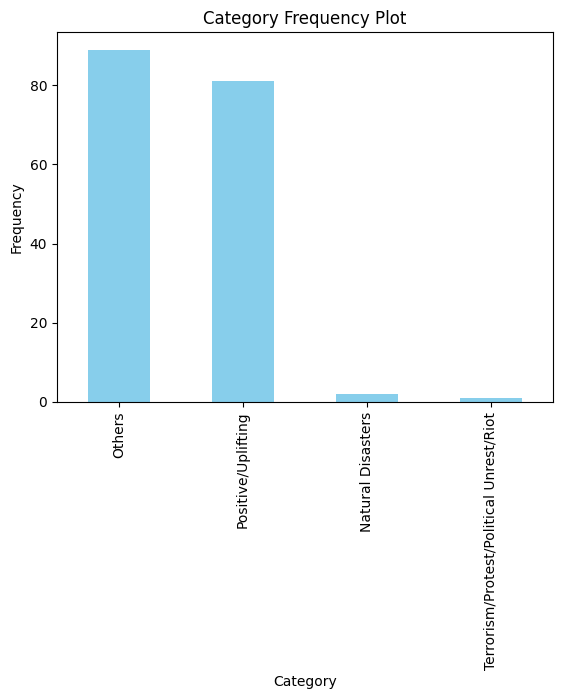

In [19]:
import matplotlib.pyplot as plt

# Counting the occurrences of each category
category_counts = sql_dump_df['Category'].value_counts()

# Ploting the frequency
category_counts.plot(kind='bar', color='skyblue')
plt.title('Category Frequency Plot')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()
